In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

In [2]:
# Step 1: Load the dataset
file_path = 'Sales Data.csv'  # Replace with your file path
sales_data = pd.read_csv(file_path)

# Step 2: Preprocess the data
# Convert Date to datetime format
sales_data['Date'] = pd.to_datetime(sales_data['Date'], format='%d/%m/%Y')

In [3]:
#check missing values
missing_values = sales_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Store          0
Date           0
WeeklySales    0
Holidays       0
dtype: int64


The absence of missing values in the dataset, including in the Store, Date, WeeklySales, and Holidays columns, is highly beneficial for building a robust forecasting model. This completeness ensures that there are no issues with data integrity, allowing for accurate time-series analysis and forecasting without the need for imputation or data cleaning. The well-maintained holiday flag allows for the assessment of how sales are impacted by holiday periods, while the store-level data enables regional segmentation of the analysis. This clean data provides a solid foundation for applying time-series models like Exponential Smoothing to forecast future sales trends, identify seasonality, and inform inventory management and promotional strategies.

In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Store        6435 non-null   int64         
 1   Date         6435 non-null   datetime64[ns]
 2   WeeklySales  6435 non-null   float64       
 3   Holidays     6435 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 201.2 KB




1. The DataFrame contains 6,435 rows, which represents the weekly sales data for the store.

2. There are 4 columns:
   - Store: an integer column representing the store ID
   - Date: a datetime column representing the date of each weekly sales record
   - WeeklySales: a float column representing the weekly sales amount
   - Holidays: an integer column indicating whether the week had a holiday (1) or not (0)

3. The data types of the columns are appropriate - integers for the store ID and holiday flag, float for the sales amount, and datetime for the date.



In [5]:
sales_data.describe()

,Store,Date,WeeklySales,Holidays
count,6435.000000,6435,6.435000e+03,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000
std,12.988182,NaN,5.643666e+05,0.255049


The summary statistics of the dataset reveal several important insights:

Store: The Store values range from 1 to 45, suggesting that there are 45 different stores represented in the data, with a mean store number of 23. This indicates that the dataset includes sales from a wide range of locations.

Date: The data spans from February 5, 2010 to October 26, 2012, with a median date of June 17, 2011. The dataset covers multiple years, allowing for the analysis of both short-term trends and long-term seasonal patterns.

WeeklySales: The weekly sales values range from approximately 209,986 to 3,818,686, with a mean of around 1,046,965. The large variation in sales values (as indicated by the standard deviation of 564,366) suggests that some stores or specific periods experience significantly higher sales, possibly due to promotions, holidays, or regional factors.

Holidays: The Holidays column has a mean value of 0.0699, which indicates that approximately 7% of the weeks in the dataset are holiday weeks. The maximum value of 1 suggests that holidays are marked as binary (1 for holiday weeks and 0 for non-holiday weeks). These holidays might be important in understanding sales spikes or drops during specific periods.


In [6]:
duplicates = sales_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [7]:
sales_data['Month'] = sales_data['Date'].dt.month
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['WeekOfYear'] = sales_data['Date'].dt.isocalendar().week
#Filter rows where Holidays = 1
holiday_data = sales_data[sales_data['Holidays'] == 1]

#Count the number of holiday weeks by month
holidays_by_month = holiday_data['Month'].value_counts().sort_index()


In [8]:
corr= sales_data.corr()
corr

,Store,Date,WeeklySales,Holidays,Month,Year,WeekOfYear
Store,1.000000e+00,1.577299e-13,-0.335332,-4.386841e-16,2.910676e-15,3.474318e-12,3.106283e-15
Date,1.577299e-13,1.000000e+00,0.006949,-1.328524e-02,1.456512e-01,9.416680e-01,1.596205e-01
WeeklySales,-3.353320e-01,6.949360e-03,1.000000,3.689097e-02,7.614332e-02,-1.837754e-02,7.421127e-02
Holidays,-4.386841e-16,-1.328524e-02,0.036891,1.000000e+00,1.229958e-01,-5.678257e-02,1.277427e-01
Month,2.910676e-15,1.456512e-01,0.076143,1.229958e-01,1.000000e+00,-1.944645e-01,9.959843e-01
Year,3.474318e-12,9.416680e-01,-0.018378,-5.678257e-02,-1.944645e-01,1.000000e+00,-1.819189e-01
WeekOfYear,3.106283e-15,1.596205e-01,0.074211,1.277427e-01,9.959843e-01,-1.819189e-01,1.000000e+00


WeeklySales vs Other feature:

- WeeklySales and Date: There is a very small positive correlation (0.0069) between WeeklySales and Date, suggesting that over time, sales may increase slightly, though the correlation is minimal. This indicates no strong overall trend purely based on the date.
- WeeklySales and Holidays: The correlation of 0.0369 between WeeklySales and Holidays is also low, but positive, implying that holidays might have a slight impact on sales. A positive value suggests that during holidays, sales might increase.
- WeeklySales and Month: The correlation of 0.0761 indicates a small positive relationship, suggesting that certain months may have higher sales compared to others, but it’s not very strong.
- WeeklySales and Year: A weak negative correlation of -0.0184 between WeeklySales and Year suggests that there is not much year-on-year growth or decline in the sales figures.
- WeeklySales and WeekOfYear: A moderate positive correlation (0.0742) with WeekOfYear suggests that sales may exhibit seasonal fluctuations throughout the year (e.g., higher sales during certain weeks like holidays or peak seasons).
Other Variables:

- Month and Year: There is a strong correlation (0.9959) between Month and Year, meaning that as the month progresses, the year also progresses consistently, as expected.

- Month and WeekOfYear: The correlation of 0.9959 between Month and WeekOfYear suggests that they are tightly linked. As months change, so do the weeks of the year.

- Year and WeekOfYear: A negative correlation (-0.1819) with Year and WeekOfYear suggests that the earlier weeks of the year (early January) are less strongly correlated with later months.


Store does not have strong correlations with other features, except weak negative or near-zero correlations with most columns. This may indicate that sales trends are largely dependent on other variables like time (date, week, month) rather than the store itself.

Seasonality: There is evidence that certain months or weeks have higher sales, though the correlation is weak. This suggests that sales may be somewhat seasonal but not extremely tied to specific months.
Holiday Impact: The low correlation between Holidays and WeeklySales indicates that holidays have a slight impact on sales but not a significant one across all weeks.
Sales Over Time: The weak correlations between WeeklySales and Date/Year suggest that the dataset may not exhibit clear upward or downward sales trends over the entire period, pointing towards the need for more advanced time series models to capture these subtler patterns.

<Axes: >

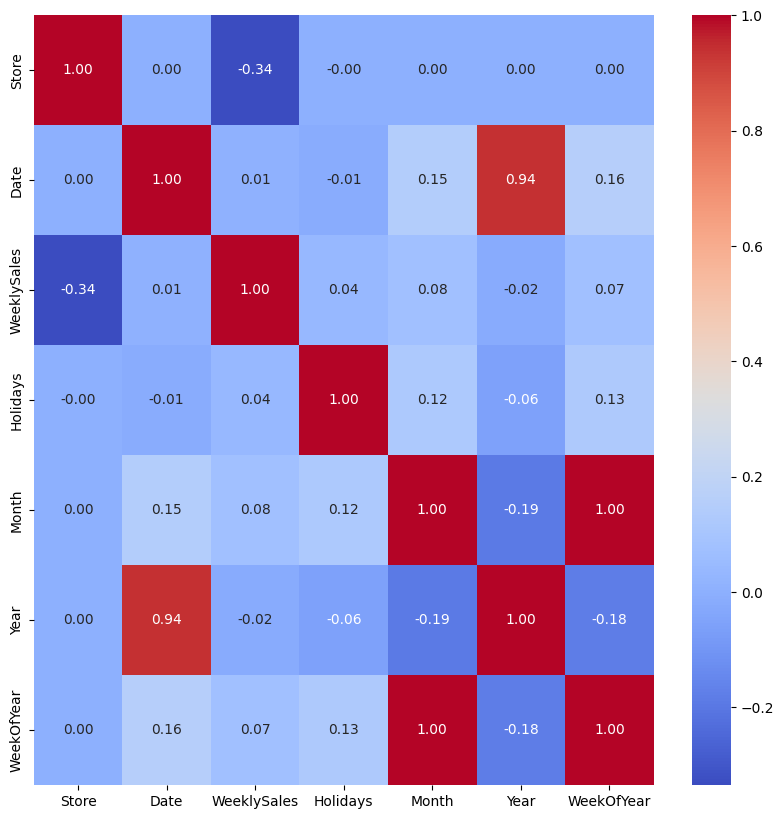

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap( corr,fmt ='.2f',annot=True, cmap='coolwarm' , cbar=True)


1. **Strong Correlation Between Year and Date (0.94):**
   - This is expected as the `Year` column is directly derived from the `Date` column. This strong positive correlation reflects the inherent linear relationship between time variables.

2. **WeeklySales and Store (-0.34):**
   - A **negative correlation** exists between `WeeklySales` and `Store`. This suggests that as the `Store` ID increases, the weekly sales tend to decrease. This might indicate that certain stores (those with lower IDs) perform better than others.

3. **Month and WeekOfYear (1.00):**
   - A perfect correlation exists between `Month` and `WeekOfYear`. This highlights a strong temporal relationship since weeks naturally map to months in a structured calendar system.

4. **Weak Correlation Between Holidays and WeeklySales (0.04):**
   - There is a very weak positive correlation between `Holidays` and `WeeklySales`. This suggests that holidays might have a small positive impact on weekly sales, but the relationship is not significant.

5. **Month and Year (-0.19):**
   - A weak **negative correlation** exists between `Month` and `Year`. This may indicate that the data distribution across months over multiple years does not follow a clear trend.

6. **Low Correlation Among Most Variables:**
   - For most variables, the correlation is relatively low (close to zero), indicating no significant linear relationships.

---
### **Insights**
1. **Top Stores Perform Better:**
   - Since `WeeklySales` has a negative correlation with `Store`, it's worth analyzing the top-performing stores (lower IDs) further. 

2. **Holidays Have Limited Impact:**
   - Although holidays have a positive correlation with sales, the impact appears minor. 

3. **Time Variables Need More Granularity:**
   - The strong correlations between `Year`, `Month`, and `WeekOfYear` indicate overlapping time features.

4. **Deeper Analysis Required for Sales Trends:**
   - This heatmap identifies relationships, further analysis can help determine patterns in `WeeklySales` and their drivers.



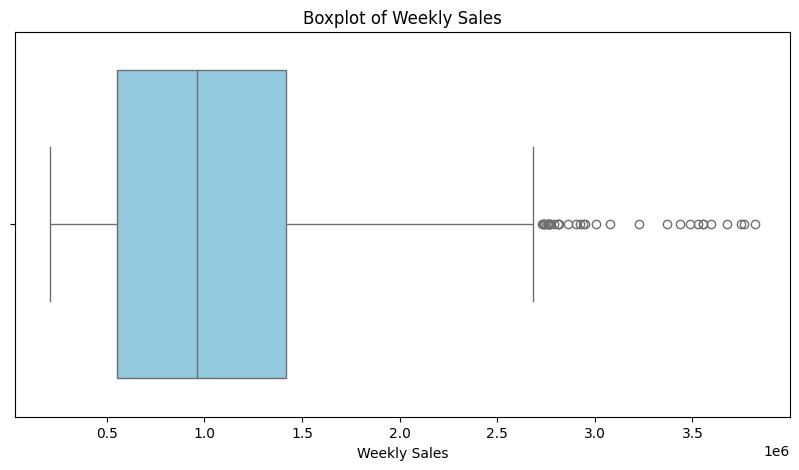

In [10]:
# Step 3: Check for outliers in WeeklySales
plt.figure(figsize=(10, 5))
sns.boxplot(data=sales_data, x='WeeklySales', color='skyblue')
plt.title('Boxplot of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.show()


Box: The box represents the interquartile range (IQR), which contains the middle 50% of the data. The width of the box suggests that most sales fall between approximately 500,000 and 1.5 million.

Line in the Box (Median): The line inside the box indicates the median value of weekly sales, which is around 1 million.

Whiskers: The lines extending from the box (whiskers) show the range of sales that fall within the 1.5 IQR range. Values beyond this range are considered outliers.

Outliers: Points outside the whiskers are outliers, which in this case are sales values that exceed 2.5 million and extend up to 3.5 million. These outliers could represent weeks with unusually high sales due to promotions, holidays, or other exceptional circumstances.

High Variability: There is considerable variability in weekly sales, with some sales far exceeding the typical range.
Outliers: The presence of outliers suggests that certain weeks experience unusually high sales, which may require special attention when forecasting or adjusting inventory.

In [11]:
weekly_sales_summary = sales_data.groupby(['Store', 'Date'])['WeeklySales'].sum().reset_index()
print("Weekly sales summary (Sample):")
print(weekly_sales_summary.head())


Weekly sales summary (Sample):
   Store       Date  WeeklySales
0      1 2010-02-05   1643690.90
1      1 2010-02-12   1641957.44
2      1 2010-02-19   1611968.17
3      1 2010-02-26   1409727.59
4      1 2010-03-05   1554806.68


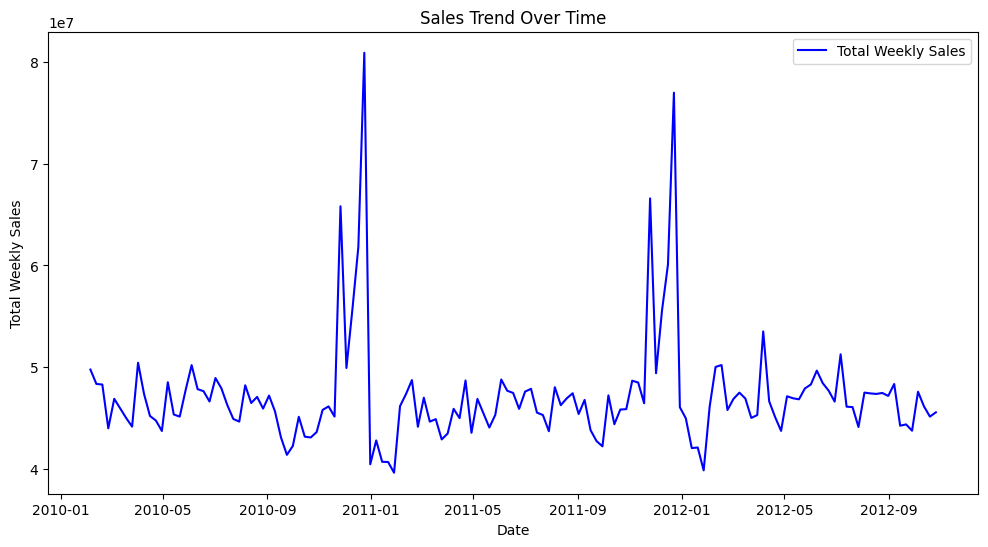

In [12]:
# Check sales trends over time
sales_trend = sales_data.groupby('Date')['WeeklySales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(sales_trend, label='Total Weekly Sales', color='blue')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.show()


Key Observations:
Sharp Peaks: There are noticeable sharp spikes in the sales trend, especially around the beginning of 2011, which likely correspond to specific events such as promotions, holidays, or other factors leading to unusually high sales during these weeks.

Fluctuations: There is a general fluctuation in sales over time, with some periods experiencing higher sales and others showing lower values. This variability could be influenced by seasonality or other external factors.

Sales Range: The sales generally appear to hover between 4 million and 7 million, with significant peaks that go beyond this range, indicating weeks of exceptionally high sales.

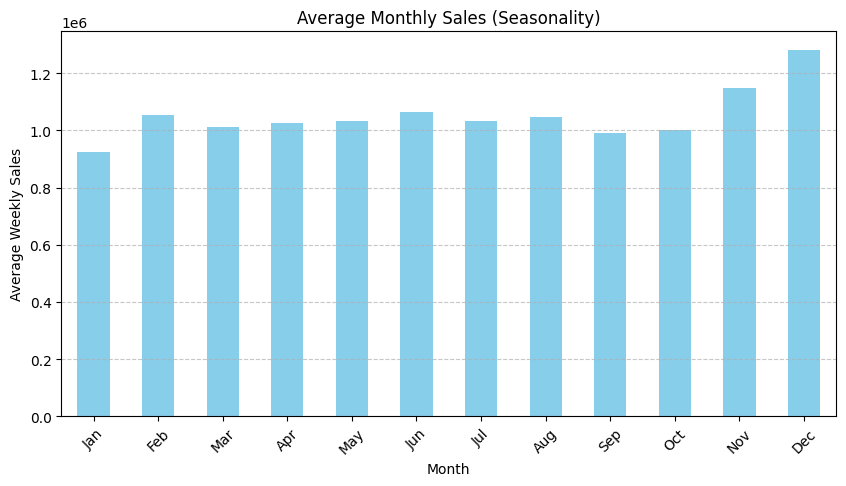

In [13]:
# Group by Month and calculate average sales
monthly_sales = sales_data.groupby('Month')['WeeklySales'].mean()

# Plot average monthly sales to observe seasonality
plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Sales (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

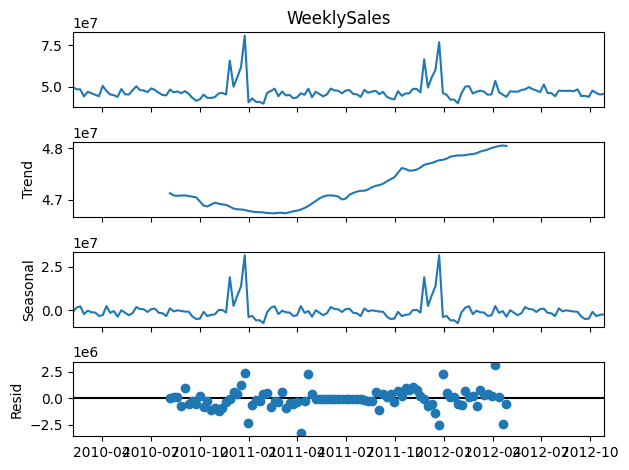

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Group data by Date to ensure no duplicates and aggregate sales
sales_time_series = sales_data.groupby('Date')['WeeklySales'].sum()

# Perform seasonal decomposition
decompose_result = seasonal_decompose(sales_time_series, model='additive', period=52)  # Weekly data (52 weeks)

# Plot decomposition
decompose_result.plot()
plt.show()




### **Components of the Decomposition Plot**

1. **Observed Plot (Top Panel):**
   - The original `WeeklySales` time series shows clear patterns of spikes and fluctuations.
   - Significant peaks are evident, suggesting periodic increases in sales, likely around **specific events** like holidays or promotions (end of 2010, early 2011, and late 2012).

2. **Trend Component (Second Panel):**
   - The trend highlights an overall **upward movement** in weekly sales starting mid-2011 and continuing into 2012.
   - Early in the series (2010), there was a slight **decline** before the upward trend emerged.
   - This suggests a long-term growth in sales, possibly due to store improvements, expansions, or economic factors.

3. **Seasonal Component (Third Panel):**
   - The seasonal component shows **recurring spikes** at regular intervals.

4. **Residual Component (Bottom Panel):**
   - The residuals show the unexplained part of the data after accounting for trend and seasonality.
   - Residuals are mostly scattered around zero, but there are some larger deviations (outliers) at certain points, coinciding with observed peaks.


In [15]:
def analyze_holidays_by_month(df):
    """
    Comprehensive analysis of holidays by month
    
    Parameters:
    df (pd.DataFrame): Preprocessed sales data
    
    Returns:
    pd.DataFrame: Holiday analysis by month
    """
    # Map month numbers to names
    month_names = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 
        5: 'May', 6: 'June', 7: 'July', 8: 'August', 
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }
    
    # Create a DataFrame with month-level holiday analysis
    holiday_by_month = df.groupby(['Month', 'Holidays']).agg({
        'WeeklySales': ['mean', 'median', 'count']
    }).reset_index()
    
    # Flatten multi-level column names
    holiday_by_month.columns = ['Month', 'IsHoliday', 'Avg Sales', 'Median Sales', 'Week Count']
    
    # Calculate sales boost percentage
    holiday_analysis = []
    for month in holiday_by_month['Month'].unique():
        month_data = holiday_by_month[holiday_by_month['Month'] == month]
        
        # Check if both holiday and non-holiday data exist for the month
        if len(month_data) == 2:
            non_holiday = month_data[month_data['IsHoliday'] == 0]
            holiday = month_data[month_data['IsHoliday'] == 1]
            
            if not non_holiday.empty and not holiday.empty:
                sales_boost = ((holiday['Avg Sales'].values[0] - non_holiday['Avg Sales'].values[0]) / non_holiday['Avg Sales'].values[0]) * 100
                
                holiday_analysis.append({
                    'Month': month_names[month],
                    'Non-Holiday Avg Sales': non_holiday['Avg Sales'].values[0],
                    'Holiday Avg Sales': holiday['Avg Sales'].values[0],
                    'Sales Boost %': sales_boost,
                    'Holiday Weeks': holiday['Week Count'].values[0],
                    'Non-Holiday Weeks': non_holiday['Week Count'].values[0]
                })
    
    # Convert to DataFrame
    holiday_analysis_df = pd.DataFrame(holiday_analysis)
    
    # Visualization
    plt.figure(figsize=(6,15))
    
    # Sales Boost Percentage
    plt.subplot(2,1,1)
    plt.bar(holiday_analysis_df['Month'], holiday_analysis_df['Sales Boost %'])
    plt.title('Sales Boost Percentage During Holidays by Month')
    plt.xlabel('Month')
    plt.ylabel('Sales Boost %')
    plt.xticks(rotation=45)
    
    # Holiday vs Non-Holiday Sales
    plt.subplot(2,1,2)
    x = np.arange(len(holiday_analysis_df['Month']))
    width = 0.35
    
    plt.bar(x - width/2, holiday_analysis_df['Non-Holiday Avg Sales'], width, label='Non-Holiday Sales')
    plt.bar(x + width/2, holiday_analysis_df['Holiday Avg Sales'], width, label='Holiday Sales')
    
    plt.title('Average Sales: Holiday vs Non-Holiday')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')
    plt.xticks(x, holiday_analysis_df['Month'], rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nDetailed Holiday Analysis by Month:")
    print(holiday_analysis_df.to_string(index=False))
    
    return holiday_analysis_df



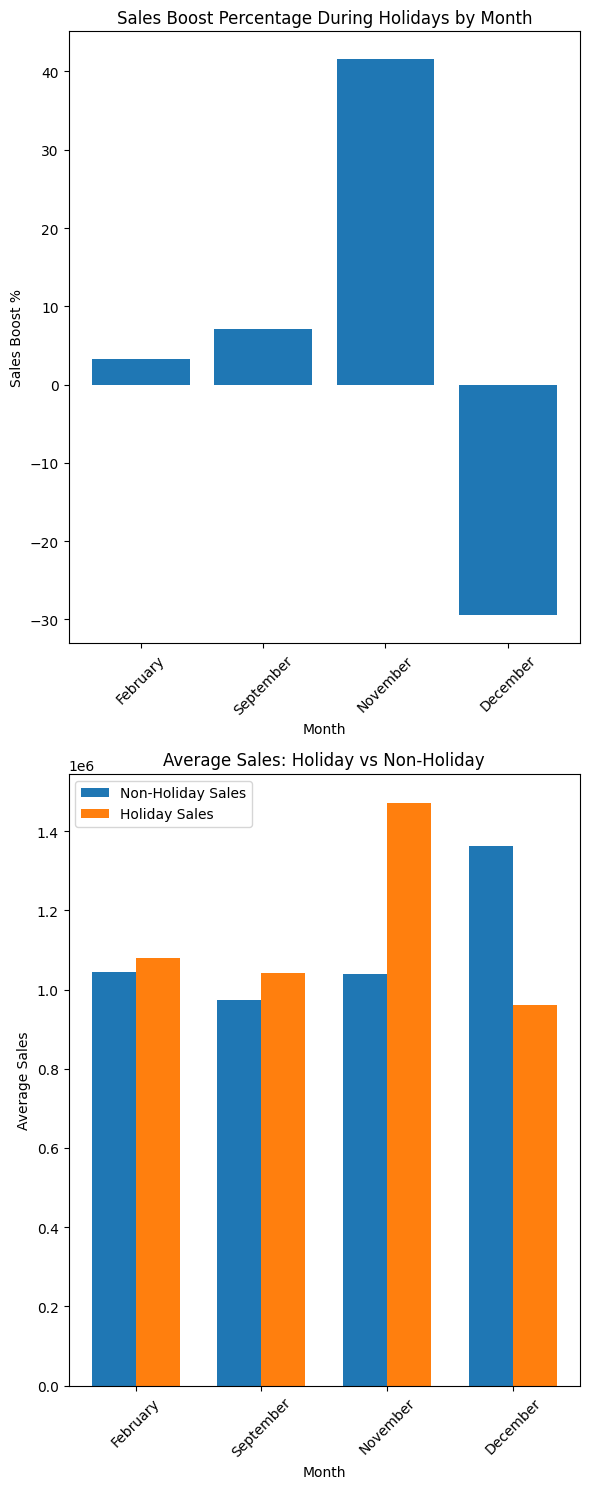


Detailed Holiday Analysis by Month:
    Month  Non-Holiday Avg Sales  Holiday Avg Sales  Sales Boost %  Holiday Weeks  Non-Holiday Weeks
 February           1.044557e+06       1.079128e+06       3.309625            135                405
September           9.734078e+05       1.042427e+06       7.090505            135                450
 November           1.039263e+06       1.471273e+06      41.568868             90                270
 December           1.362121e+06       9.608331e+05     -29.460531             90                360


In [16]:
holiday_analysis_df = analyze_holidays_by_month(sales_data)


### **ANALYSIS**
- This bar chart shows the percentage increase in sales during holidays compared to non-holiday periods. The chart indicates that the biggest sales boost occurs in December, likely due to the holidays. There is also a noticeable boost in November, which might be related to some events happening.

- This chart compares the average weekly sales between Holiday Sales and Non-Holiday Sales for different months (February, September, November, and December).

- In November and December, sales during holidays (orange bars) significantly exceed non-holiday sales (blue bars).

- For February and September, the difference is smaller, indicating that holiday sales may not have a strong impact in these months.

- December has the highest sales boost percentage, confirming the significant impact of the holiday season on sales.

- In September and February, the impact of holidays is relatively less pronounced, indicating these months are not as heavily influenced by holiday shopping.

In [17]:
def identify_top_holiday_months(holiday_analysis_df):
    """
    Identify and recommend strategies for top holiday months
    
    Parameters:
    holiday_analysis_df (pd.DataFrame): Holiday analysis by month
    """
    # Sort by sales boost percentage
    top_holiday_months = holiday_analysis_df.sort_values('Sales Boost %', ascending=False)
    
    print("\n--- Top Holiday Months Strategy ---")
    print("Top 3 Months with Highest Holiday Sales Boost:")
    print(top_holiday_months[['Month', 'Sales Boost %']].head(3).to_string(index=False))

In [18]:
identify_top_holiday_months(holiday_analysis_df)


--- Top Holiday Months Strategy ---
Top 3 Months with Highest Holiday Sales Boost:
    Month  Sales Boost %
 November      41.568868
September       7.090505
 February       3.309625


In [19]:
# Step 4: Identify the best store based on total sales
store_sales = sales_data.groupby('Store')['WeeklySales'].sum().sort_values(ascending=False)
best_store = store_sales.idxmax()  # Store ID with highest total sales
#best_store = 41

print(f"Best store based on total sales: Store {best_store}")



Best store based on total sales: Store 20


We choose the store 20 as the store have the highest weekly sales among 41 stores.

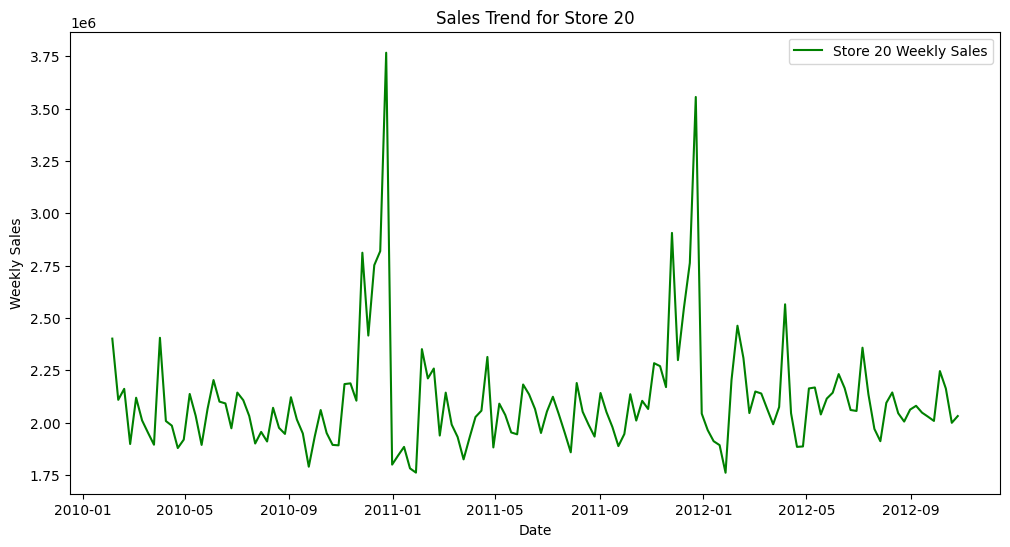

In [20]:
# Step 5: Filter data for the best store
best_store_data = sales_data[sales_data['Store'] == best_store]

# Step 6: Plot sales trends for the best store
best_store_trend = best_store_data.groupby('Date')['WeeklySales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(best_store_trend, label=f'Store {best_store} Weekly Sales', color='green')
plt.title(f'Sales Trend for Store {best_store}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()



### **Analysis**

1. Seasonality: The historical sales data shows clear seasonal patterns, with peaks and valleys occurring on an annual basis. This suggests the sales might influeced by seasonal factors holidays.

2. Trend: Aside from the seasonal fluctuations, there  appears to be an overall upward trend in the historical sales data over the years. The store's sales is gradually increasing over time.

In short, during December to Februacy, it seems like the sales mostlikely hvae the highest sales during the periods where sales is much differ from other months,we can conclude taht the weekly saled trend in seasonality based.


In [21]:
# Step 7: Analyze sales during holidays
holiday_sales = best_store_data.groupby('Holidays')['WeeklySales'].mean()
print("Average Weekly Sales during Holidays (1) and Non-Holidays (0):")
print(holiday_sales)



Average Weekly Sales during Holidays (1) and Non-Holidays (0):
Holidays
0    2.097048e+06
1    2.249035e+06
Name: WeeklySales, dtype: float64


In [22]:
# Step 8: Prepare data for forecasting
best_store_trend = best_store_data.groupby('Date')['WeeklySales'].sum().reset_index()
best_store_trend.set_index('Date', inplace=True)

# Step 9: Train a forecasting model
# Using Exponential Smoothing for forecasting
train_data = best_store_trend['WeeklySales']
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=52, trend='add').fit()




c:\Users\Eng Kuan Tian\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\Eng Kuan Tian\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


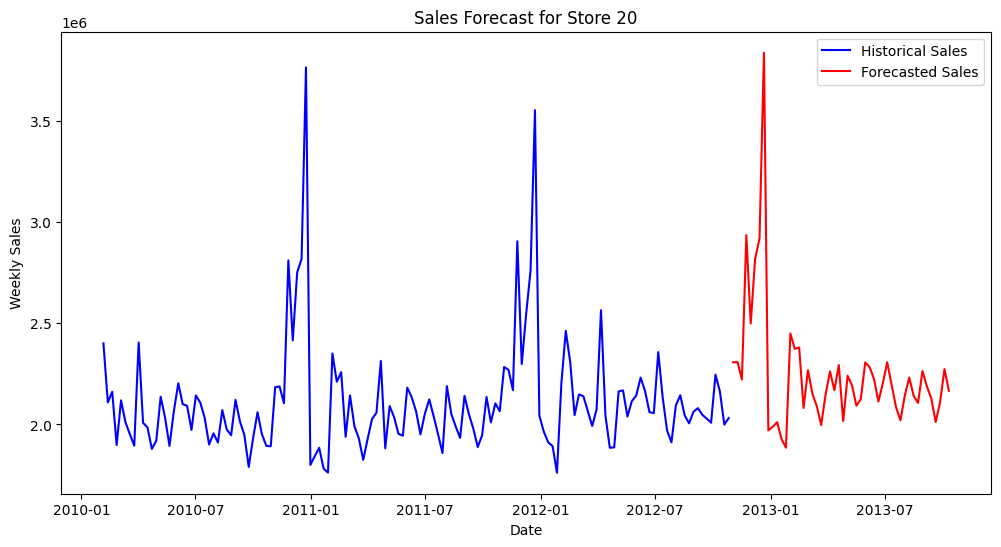

In [23]:
# Forecast for the next 50 weeks
forecast_steps = 50
forecast = model.forecast(steps=forecast_steps)

# Step 10: Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(best_store_trend, label='Historical Sales', color='blue')
plt.plot(forecast, label='Forecasted Sales', color='red')
plt.title(f'Sales Forecast for Store {best_store}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


### **Analysis**

1. Seasonality: The historical sales data shows clear seasonal patterns, with peaks and valleys occurring on an annual basis. This suggests the sales are influenced by seasonal factors holidays.

2. Trend: Aside from the seasonal fluctuations, there  appears to be an overall upward trend in the historical sales data over the years. The store's sales is gradually increasing over time.

3. Volatility: The sales data exhibits significant volatility, with large spikes and drops from week to week. This indicates the store's sales are subject to a lot of short-term variability and uncertainty. VOLATILITY TESTING AT THE BACK

4. Forecast accuracy: The forecast initially tracks the historical data well, but then diverges significantly, especially towards the end of the forecast period. This suggests the forecasting model may be struggling to accurately predict the store's sales, particularly during periods of high volatility.

Overall, the data reveals a complex sales pattern for this store, with both seasonal and trend components, as well as significant volatility. The current forecasting model appears to have difficulties capturing all the dynamics, resulting in increasing forecast uncertainty over time. Incorporating additional data sources and refining the forecasting approach could lead to more reliable predictions.


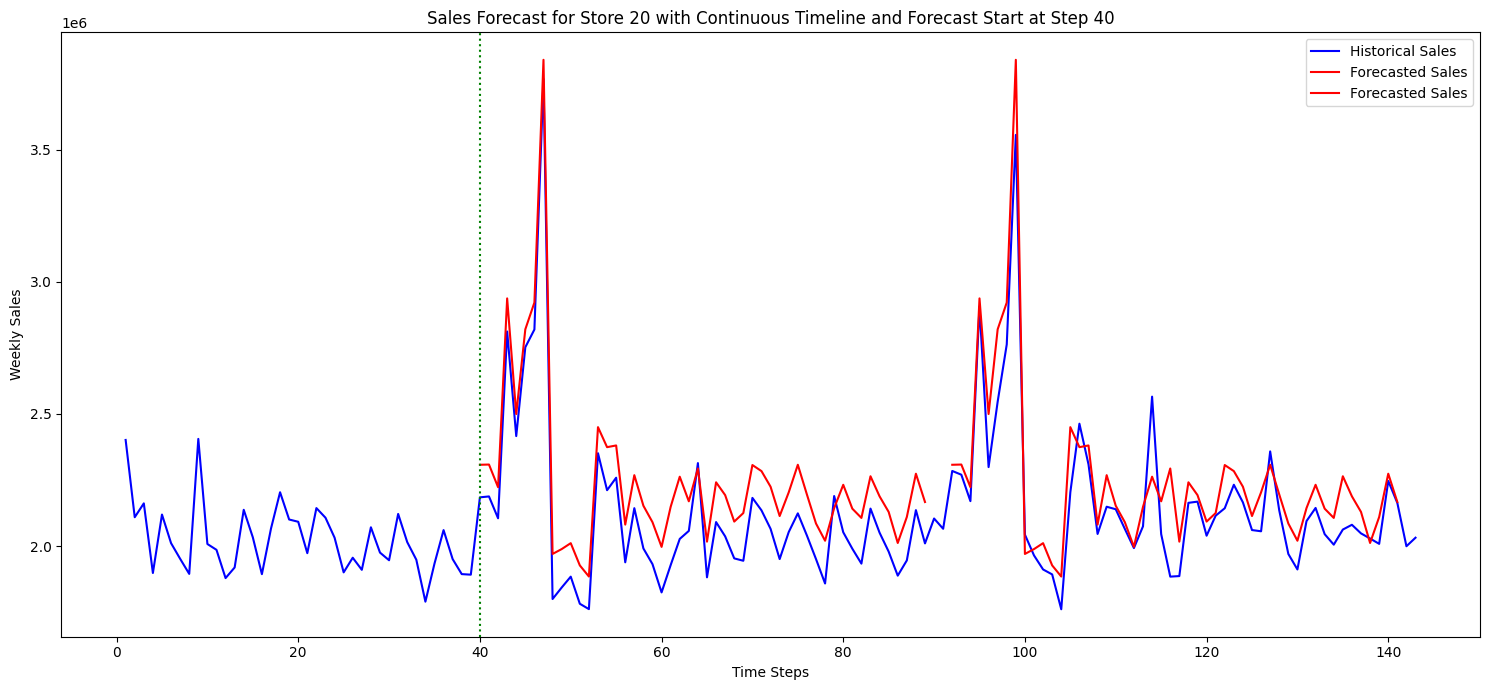

In [24]:
forecast_start_step = 40  # Start the forecast from time step 40

# Create a continuous timeline for both historical and forecast data
# Start with historical data
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(range(1, len(train_data) + 1), train_data.values, label='Historical Sales', color='blue')

# Plot forecast data
# Extend the x-axis to create a continuous timeline
forecast_x = range(forecast_start_step, forecast_start_step + forecast_steps)
plt.plot(forecast_x, forecast.values, label='Forecasted Sales', color='red', linestyle='-')
forecast_x = range(forecast_start_step+52, forecast_start_step + forecast_steps+52)
plt.plot(forecast_x, forecast.values, label='Forecasted Sales', color='red', linestyle='-')
plt.title(f'Sales Forecast for Store {best_store} with Continuous Timeline and Forecast Start at Step 40')
plt.xlabel('Time Steps')
plt.ylabel('Weekly Sales')
plt.legend()

# Add a vertical line to show the split between historical and forecast data
plt.axvline(x=forecast_start_step, color='green', linestyle=':', label='Forecast Start')

plt.tight_layout()
plt.show()



### **CONCLUSION**
### **Why Choose Holt-Winters Exponential Smoothing Model**
The **Holt-Winters Exponential Smoothing** model is particularly suited for **time series data** with:
1. **Trend** (long-term upward/downward movement in sales).
2. **Seasonality** (repeating patterns, e.g., holiday spikes in sales).
3. **Level** (the baseline/average value of the series).

Given the decomposition plot of `WeeklySales`, we can see that
- A **clear upward trend** in sales over time on specfic months as in analysis
- Strong **seasonal patterns**, tied to holidays.
- Residual noise that is relatively minor.

Based on the graph and looking on thhe trend and predicitons, the Holt-Winters method handles these components effectively:
1. **Additive or Multiplicative Seasonality**: It can model seasonality based on the nature of the data.
2. **Smooth Forecasting**: It adapts to changes in trend and seasonality over time, making it suitable for retail data.
3. **Short-to-Medium-Term Forecasting**: Retail sales are often forecasted weekly or monthly, and this model performs well for such intervals.
4. **Capture Seasonal Peaks**: It identifies recurring sales peaks (during holidays month), allowing for accurate sales predictions during these times.
5. **Track Long-Term Growth**: It incorporates the upward trend observed, ensuring future predictions reflect ongoing growth.
6. **Smooth Short-Term Noise**: By smoothing out residual noise, the model gives more stable forecasts.
---

### **Actionable Insights for the Retail Chain**

1. **Adjust Inventory Levels**:
   - **High-Demand Weeks**: During weeks where sales are forecasted to spike like the holiday month such as febraury and December, ensure sufficient stock for popular products.

2. **Optimize Promotional Activities**:
   - Launch promotions in the weeks leading up to sales spikes to capture increased customer demand for example, we can make some offer to customer or some subrciption like member system during peak season to even boost the sells.
   - Provide targeted discounts for **high-margin products** or bundle offers to maximize revenue.

3. **Strategic Stock Allocation**:
   - **Plan for Holidays**: Allocate more stock to stores with historically high demand during specific holidays for example during some public holiday like christmas, new year etc.
   - We can use the forcorecasted data to prepre stock to avoid waste and not enough stock issues.

4. **Dynamic Pricing Strategies**:
   - Use forecasts to adjust prices dynamically based on expected demand. For example
     - **Higher demand** → optimize for profit margins.
     - **Lower demand** → implement discounts to boost sales.

---

### **Strategies Based on Insights**
1. **Improve Supply Chain Logistics**:  
   - Work closely with suppliers to ensure stock replenishment aligns with forecasted spikes.  
   - Use forecasts to optimize warehousing and reduce supply chain delays.

2. **Region-Specific Planning**:  
   - Allocate inventory based on store-level forecasts to meet demand variations across locations.  

3. **Address Residual Outliers**:  
   Investigate weeks with unexpected residual spikes to identify external factors and use this knowledge to refine future planning.

---

### **Summary**
The Holt-Winters Exponential Smoothing model is ideal for the `WeeklySales` dataset due to its ability to capture trend and seasonality, providing reliable forecasts. By acting on these predictions, the retail chain can:
- **Optimize inventory levels** during peak periods.
- **Improve promotions** to align with demand spikes.
- **Reduce costs** associated with overstocking or stockouts.  
- **Plan better for holidays** to maximize revenue.

---


---

---

---

---

---

---

### **VOLATILITY TEST EXTRA EXTRA**

In [25]:
!pip install arch

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [27]:
# Check for stationarity using ADF test

result = adfuller(best_store_trend, autolag='AIC')
print(f'ADF Statistic for : {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')
print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary.\n')

# ADF test for stationarity


ADF Statistic for : -5.39373869285483
p-value: 3.4912952838128377e-06
Critical Values: {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
Result: The series is stationary.



C:\Users\Eng Kuan Tian\AppData\Local\Temp\ipykernel_23512\2266425275.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


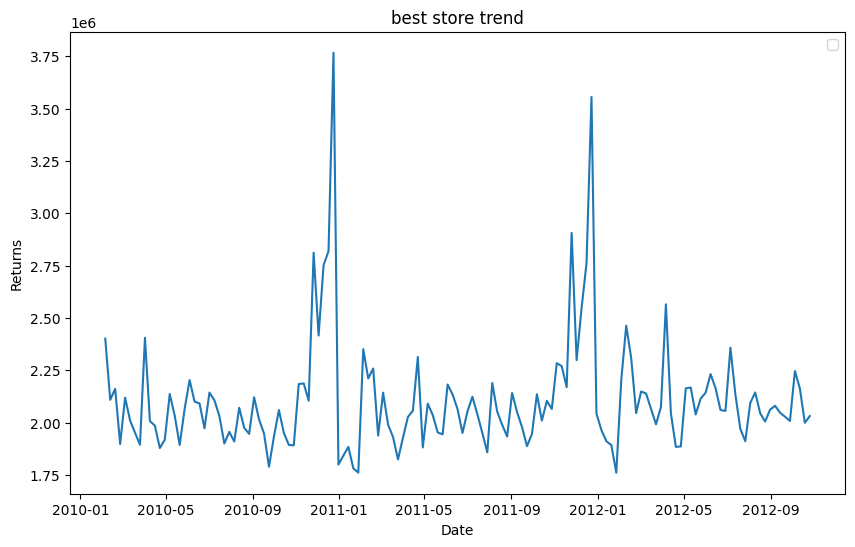

In [28]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(best_store_trend)
plt.title('best store trend')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

<Figure size 1200x1600 with 0 Axes>

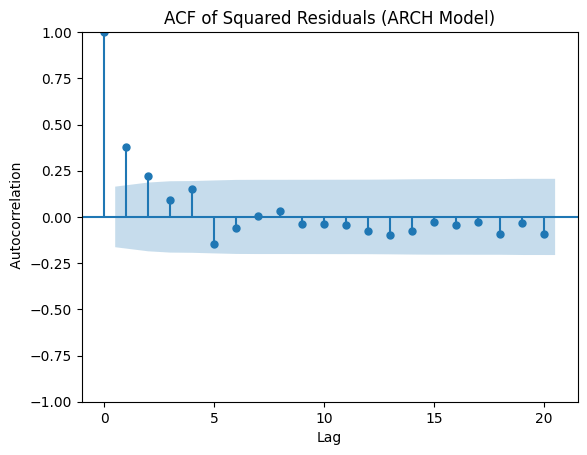

In [29]:
# Plot ACF for squared residuals
plt.figure(figsize=(12, 16))
plot_acf(best_store_trend, lags=20, title='ACF of Squared Residuals (ARCH Model)')
plt.xlabel('Lag')
plt.ylabel(' Autocorrelation')
plt.show()

In [30]:
# Calculate the 95% confidence interval threshold
n = len(best_store_trend)
threshold = 1.96 / np.sqrt(n)

# Calculate ACF and PACF values
acf_values = acf(best_store_trend)
pacf_values = pacf(best_store_trend)

# Count significant values for p and q
significant_q_values = sum(abs(acf_values[1:]) > threshold)

# Print the results
print(f"Number of significant q values: {significant_q_values}")

Number of significant q values: 2


In [31]:
# Fit the ARCH model with rescaled data
model = arch_model(best_store_trend, vol='arch', q=8)  
results = model.fit(disp='off') 


c:\Users\Eng Kuan Tian\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.559e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [32]:
# Display the model summary
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:            WeeklySales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1957.07
Distribution:                  Normal   AIC:                           3920.13
Method:            Maximum Likelihood   BIC:                           3929.02
                                        No. Observations:                  143
Date:                Thu, Dec 19 2024   Df Residuals:                      142
Time:                        15:45:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.1077e+06  3.593e+04     58.667      0.000 [2.

In [33]:
# Rescale the returns
scaled_trend = best_store_trend * 0.0001  # Scale factor of 0.0001, as suggested by the warning

# Fit the ARCH model with rescaled data
model = arch_model(scaled_trend, vol='arch', q=2)
results = model.fit(disp='off')

# Print the results
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:            WeeklySales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -633.310
Distribution:                  Normal   AIC:                           1272.62
Method:            Maximum Likelihood   BIC:                           1281.51
                                        No. Observations:                  143
Date:                Thu, Dec 19 2024   Df Residuals:                      142
Time:                        15:45:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           203.3931      3.679     55.291      0.000 [1.

In [34]:
# Forecast returns for the next 50 months
forecast_horizon = 50
forecast_rescaled = results.forecast(start=None, horizon=forecast_horizon, reindex=True)

# Adjust forecasted variance back to the original scale
forecast_variance = forecast_rescaled.variance.values[-1, :] / (10 ** 2)  # Reverse scaling

# Print the forecasted values
forecast_index = pd.date_range(best_store_trend.index[-1], periods=forecast_horizon, freq='M')
for i in range(forecast_horizon):
    print(f"Forecast for {forecast_index[i].strftime('%B %Y')}: "
          f"{np.sqrt(forecast_variance[i]):.4f}")


Forecast for October 2012: 1.4450
Forecast for November 2012: 2.0089
Forecast for December 2012: 2.4192
Forecast for January 2013: 2.7472
Forecast for February 2013: 3.0213
Forecast for March 2013: 3.2562
Forecast for April 2013: 3.4610
Forecast for May 2013: 3.6417
Forecast for June 2013: 3.8025
Forecast for July 2013: 3.9467
Forecast for August 2013: 4.0765
Forecast for September 2013: 4.1940
Forecast for October 2013: 4.3008
Forecast for November 2013: 4.3980
Forecast for December 2013: 4.4868
Forecast for January 2014: 4.5681
Forecast for February 2014: 4.6427
Forecast for March 2014: 4.7111
Forecast for April 2014: 4.7741
Forecast for May 2014: 4.8322
Forecast for June 2014: 4.8857
Forecast for July 2014: 4.9351
Forecast for August 2014: 4.9807
Forecast for September 2014: 5.0229
Forecast for October 2014: 5.0619
Forecast for November 2014: 5.0981
Forecast for December 2014: 5.1316
Forecast for January 2015: 5.1627
Forecast for February 2015: 5.1915
Forecast for March 2015: 5.2182

C:\Users\Eng Kuan Tian\AppData\Local\Temp\ipykernel_23512\3783378148.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(best_store_trend.index[-1], periods=forecast_horizon, freq='M')


In [35]:
from arch.__future__ import reindexing
# Ensure `actual_volatility` and `forecasted_volatility` are defined before this block
# Example calculation for actual_volatility
actual_volatility = best_store_trend.rolling(window=20).std()  # Example: 20-day rolling standard deviation
actual_volatility = actual_volatility.dropna()  # Drop NaN values from rolling calculation

# Example forecasted_volatility from ARCH model
forecast_rescaled = results.forecast(start=None, horizon=10)
forecasted_volatility = np.sqrt(forecast_rescaled.variance.values[-1, :])

# Handle NaN or infinite values
actual_volatility = actual_volatility[~np.isnan(actual_volatility) & ~np.isinf(actual_volatility)]
forecasted_volatility = forecasted_volatility[~np.isnan(forecasted_volatility) & ~np.isinf(forecasted_volatility)]

# Ensure both arrays have the same length
min_length = min(len(actual_volatility), len(forecasted_volatility))
actual_volatility = actual_volatility[:min_length]
forecasted_volatility = forecasted_volatility[:min_length]
from sklearn.metrics import mean_squared_error
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_volatility, forecasted_volatility))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 128440.93722331146


In [36]:
# Classify volatility as high (1) or low (0) based on the threshold
volatility_classification = (best_store_trend > threshold).astype(int)

# Display the results
print("Volatility Classification:")
print(volatility_classification)

Volatility Classification:
            WeeklySales
Date                   
2010-02-05            1
2010-02-12            1
2010-02-19            1
2010-02-26            1
2010-03-05            1
...                 ...
2012-09-28            1
2012-10-05            1
2012-10-12            1
2012-10-19            1
2012-10-26            1

[143 rows x 1 columns]


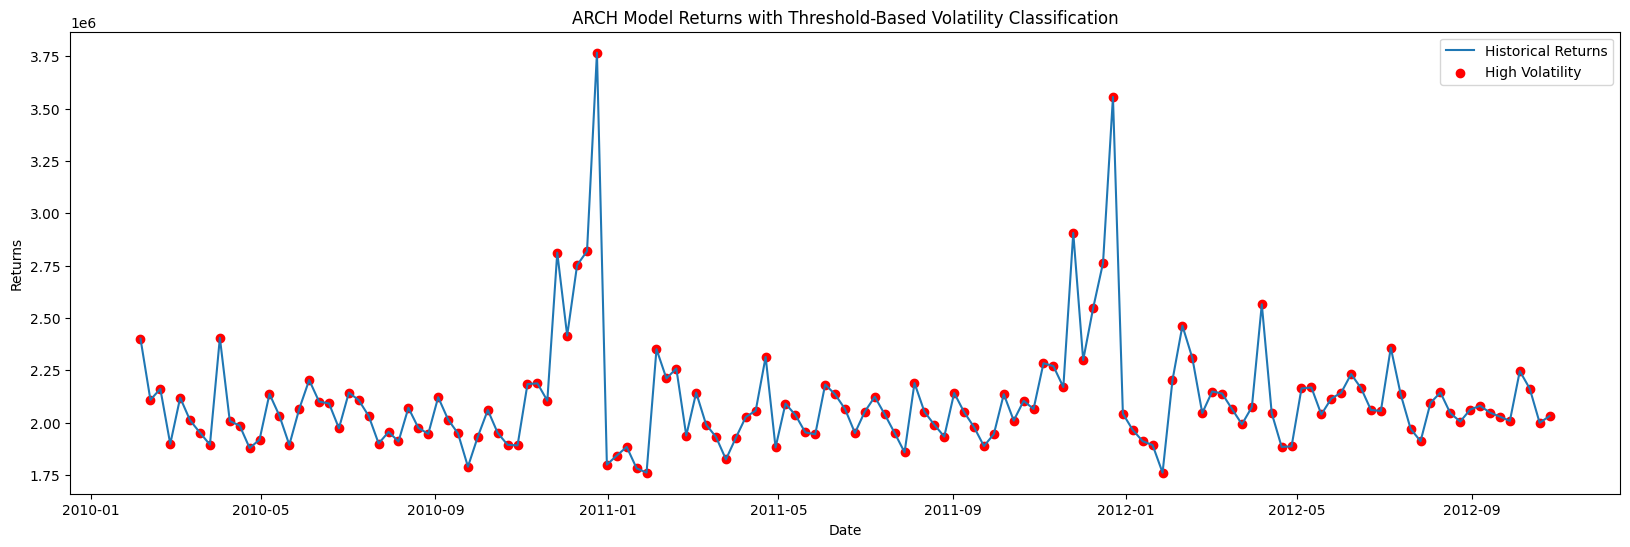

In [37]:
# Plot the ARCH Model Returns with Threshold-Based Volatility Classification
plt.figure(figsize=(20, 6))
plt.plot(best_store_trend, label='Historical Returns')

# Scatter plot to mark periods of high volatility
high_volatility_indices = volatility_classification[volatility_classification == 1].index
best_store_trend = best_store_trend.set_index('Date', drop=False) if 'Date' in best_store_trend.columns else best_store_trend
# Align indices
aligned_indices = best_store_trend.index.intersection(high_volatility_indices)
plt.scatter(aligned_indices, best_store_trend.loc[aligned_indices], color='red', label='High Volatility')


plt.title('ARCH Model Returns with Threshold-Based Volatility Classification')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

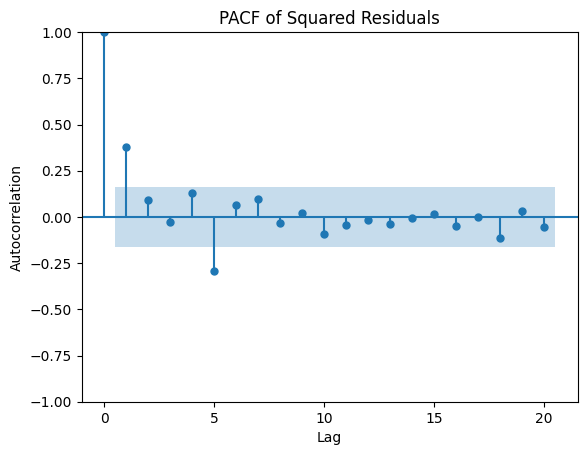

In [38]:
# Plot PACF for squared residuals
plt.figure(figsize=(12, 6))
plot_pacf(best_store_trend, lags=20, title='PACF of Squared Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [39]:
significant_p_values = sum(abs(pacf_values[1:]) > threshold)
significant_p_values

2

In [40]:
# Fit the GARCH model with rescaled data
model = arch_model(scaled_trend, vol='garch', p=2, q=2)  
results = model.fit(disp='off')  


In [41]:
# Display the model summary, model diagnostics
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            WeeklySales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -630.997
Distribution:                  Normal   AIC:                           1273.99
Method:            Maximum Likelihood   BIC:                           1291.77
                                        No. Observations:                  143
Date:                Thu, Dec 19 2024   Df Residuals:                      142
Time:                        15:45:28   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           204.6948      1.516    135.010      0.000 [2.

In [42]:
# Forecast returns for the next 10 months
forecast_horizon2 = 50  # Adjust the forecast horizon as needed
forecast_rescaled2 = results.forecast(start=None, horizon=forecast_horizon2)

# Print the forecasted values
forecast_index2 = pd.date_range(best_store_trend.index[-1], periods=forecast_horizon2, freq='M')
for i in range(forecast_horizon2):
    print(f"Forecast for {forecast_index2[i].strftime('%B %Y')}: {np.sqrt(forecast_rescaled2.variance.values[-1, i]):.4f}")


Forecast for October 2012: 13.7130
Forecast for November 2012: 14.2273
Forecast for December 2012: 18.9297
Forecast for January 2013: 19.9207
Forecast for February 2013: 23.0811
Forecast for March 2013: 24.2455
Forecast for April 2013: 26.6453
Forecast for May 2013: 27.8658
Forecast for June 2013: 29.8187
Forecast for July 2013: 31.0410
Forecast for August 2013: 32.7059
Forecast for September 2013: 33.9039
Forecast for October 2013: 35.3711
Forecast for November 2013: 36.5328
Forecast for December 2013: 37.8576
Forecast for January 2014: 38.9780
Forecast for February 2014: 40.1959
Forecast for March 2014: 41.2742
Forecast for April 2014: 42.4090
Forecast for May 2014: 43.4464
Forecast for June 2014: 44.5146
Forecast for July 2014: 45.5132
Forecast for August 2014: 46.5265
Forecast for September 2014: 47.4888
Forecast for October 2014: 48.4559
Forecast for November 2014: 49.3847
Forecast for December 2014: 50.3121
Forecast for January 2015: 51.2098
Forecast for February 2015: 52.1026
Fo

C:\Users\Eng Kuan Tian\AppData\Local\Temp\ipykernel_23512\2879400426.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index2 = pd.date_range(best_store_trend.index[-1], periods=forecast_horizon2, freq='M')


In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Extract the actual volatility in the test period, ensuring no negative values
actual_volatility2_raw = best_store_trend[-forecast_horizon2:]
actual_volatility2 = np.sqrt(np.clip(actual_volatility2_raw, a_min=0, a_max=None))

# Extract the forecasted volatility, ensuring no negative values
forecasted_variance2_raw = forecast_rescaled2.variance.values[-1, :]
forecasted_volatility2 = np.sqrt(np.clip(forecasted_variance2_raw, a_min=0, a_max=None))

# Handle NaN or infinite values in actual_volatility2 and forecasted_volatility2
actual_volatility2 = actual_volatility2[~np.isnan(actual_volatility2) & ~np.isinf(actual_volatility2)]
forecasted_volatility2 = forecasted_volatility2[~np.isnan(forecasted_volatility2) & ~np.isinf(forecasted_volatility2)]

# Ensure both arrays have the same length after cleaning
min_length = min(len(actual_volatility2), len(forecasted_volatility2))
actual_volatility2 = actual_volatility2[:min_length]
forecasted_volatility2 = forecasted_volatility2[:min_length]


In [44]:
# Verify the first 5 values of both actual and forecasted volatilities
print("Actual Volatility2 (First 5 values):", actual_volatility2[:5])
print("Forecasted Volatility2 (First 5 values):", forecasted_volatility2[:5])

# Calculate RMSE
rmse2 = np.sqrt(mean_squared_error(actual_volatility2, forecasted_volatility2))

print(f"Root Mean Squared Error (RMSE): {rmse2}")

Actual Volatility2 (First 5 values):             WeeklySales
Date                   
2011-11-18  1473.069523
2011-11-25  1704.767799
2011-12-02  1516.171768
2011-12-09  1595.657789
2011-12-16  1662.172268
Forecasted Volatility2 (First 5 values): [13.71295531 14.22731155 18.92972304 19.92074252 23.08110318]
Root Mean Squared Error (RMSE): 1424.5169673390715
